# Анализ пользовательского поведения и поиск точек роста в сервисе доставки еды

## Краткое резюме

- **Контекст:** Анализируется сервис доставки еды, который столкнулся с усилением конкуренции и необходимостью поиска  
новых точек роста.
- **Поведение пользователей (Воронка):** Обнаружена критическая проблема в воронке — падение конверсии на 45% на этапе  
подтверждения телефона в мобильной версии. Решение этой проблемы потенциально может увеличить количество заказов на 50%.
- **Сегменты клиентов (RFM-анализ):**
    - **Массовый сегмент (212, 311):** Около 60% клиентов совершают покупки редко, что указывает на общую проблему с  
    вовлеченностью.
    - **Крупные "спящие" клиенты (113):** Крупный сегмент (28.3%) с высоким чеком, который давно не возвращался. Это  
    главная точка роста LTV, но и самый высокий риск - многие клиенты могут быть потеряны безвозвратно.
    - **Лояльное ядро (<1%):** Небольшие, но самые ценные сегменты (233, 223, 133), ключевые для удержания.
-  **Сегменты партнеров (K-Means кластеризация):** Определен самый прибыльный сегмент ресторанов (широкий ассортимент,  
высокий объем заказов), на котором бизнесу следует сфокусироваться.

## Бизнес-задача
Провести комплексный анализ данных для ответа на три ключевых вопроса бизнеса:
1.  **Пользователи:** Как ведут себя пользователи и как повысить их удержание (retention)?
2.  **Продукт:** Какой путь проходят пользователи в приложении и где находятся "узкие места" воронки?
3.  **Партнеры:** Как можно улучшить взаимодействие с ресторанами-партнерами?


## Этапы работы
1. Загрузка и предобработка данных
    - 1.1. Первичный анализ и структура данных
    - 1.2. Анализ пропусков
    - 1.3. Преобразование типов данных
    - 1.4. Проверка на дубликаты
2. Анализ пользовательского пути
    - 2.1. Общая воронка конверсии
    - 2.2. Сравнение воронок по платформам (Mobile vs Desktop)
3. RFM-сегментация пользователей
    - 3.1. Расчет RFM-метрик (Recency, Frequency, Monetary)
    - 3.2. Анализ и интерпретация RFM-сегментов
4. K-Means кластеризация ресторанов
    - 4.1. Подготовка признаков для кластеризации
    - 4.2. Определение оптимального числа кластеров (Метод локтя)
    - 4.3. Анализ и интерпретация кластеров
5. Итоговые выводы и рекомендации

### Данные
Анализ проведен на данных, включающих информацию о визитах, событиях, заказах и ресторанах. 

| Поле         | Описание                      |
|--------------|-------------------------------|
| `visitor_uuid` | ID анонимного посетителя      |
| `user_id`      | ID зарегистрированного пользователя |
| `device_type`  | Тип устройства (платформа)    |
| `city_id`      | ID города                    |
| `source`      | Рекламный источник           |
| `first_date`  | Дата первого визита          |
| `visit_id`    | ID сессии                   |
| `event`      | Название события            |
| `datetime`   | Дата и время события        |
| `rest_id`    | ID ресторана                |
| `object_id`  | ID блюда                   |
| `order_id`   | ID заказа                  |
| `revenue`   | Выручка от заказа (в рублях) |
| `delivery`  | Стоимость доставки (в рублях) |
| `commission` | Комиссия сервиса (в процентах) |


In [1]:
# Устанавливаем необходимые библиотеки 
%pip install pandas numpy scikit-learn matplotlib seaborn ipython tabulate -q -U

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Импортируем библиотеки

# Работа с данными
import pandas as pd
import numpy as np

# ML (KMeans и нормализация признаков)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 

# Визуализации
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import seaborn as sns

# Вспомогательные импорты
from IPython.display import Markdown, display, HTML
import io


# Пока не нужно
# import IPython
# import scipy.stats as st
# from statsmodels.stats.proportion import proportions_ztest
# from matplotlib_venn import venn2


In [ ]:
#-----------------------------------------------------------------------------
# Стили и настройки форматирования 
#-----------------------------------------------------------------------------
# цвета заголовков
display(HTML("""<style>.output_area{max-height: none !important;}
             h1{color:#D14D41;}h2{color:#DA702C;}h3{color:#D0A215;}
             h4{color:#879A39;}h5{color:#3AA99F;}h6{color:#4385BE;}
             </style>"""))

# палитра для визуализаций
pal = [
    '#C9495E',  '#50C2E5', '#38A86F',  '#D466A0', 
    "#956BBE",  "#0B8C9E", "#EAD38C",  '#17BECF'
] 


#-----------------------------------------------------------------------------
# Полезные функции
#-----------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Расширенная информация о данных
# выводит процент нулей, чтобы не прикидывать в уме сколько там нулей? 
# 4.73% или 8.19%?🤔 Это уже достаточно много чтобы не игнорировать или еще нет?
def extended_info(df):
    buf = io.StringIO()
    df.info(buf=buf)
    info_lines = buf.getvalue().splitlines()
    rn = info_lines[1].split()[1] # rows number
    
    cols = ['Name',  'Non-Null', 'Null', 'Null share', 'Dtype']

    data = [
        [' '.join(x[1:-3]), x[-3], int(rn) - int(x[-3]), 
         f'{round((int(rn) - int(x[-3]))*100 / int(rn) , 2)}%',  x[-1]]
        for row in info_lines[5:-2]
        for x in [row.split()]
    ]
    
    meta = [
        [f'**{x[0]}**', f'**{x[1]}**'] + ['']*(len(cols)-2) 
        for row  in info_lines[-2:] 
        for x  in [row.split(': ')]
    ]
    
    data += meta
    return Markdown(pd.DataFrame(data, columns=cols).to_markdown())

# ------------------------------------------------------------------------------
# уникальные значения категориальных признаков
# решает проблему неявного дублирования данных. 
# - Пример вывели уники в поле город   
#     Санкт-Петербург  
#     Санкт Петербург (без дефиса)  
#     Санкт-Петербуг (опечатка)  
#     СПб (аббревиатура)  
# - сразу видно что есть неявные дубликаты  
# - **удобно**: ввел все кат. столбцы - получил на выходе уникальные значения 
# **сразу по ВСЕМ столбцам в одной таблице**
def get_df_unique_values(df, cols=None, row_count=20, _sorted=True):
    new_cols = dict()
    
    if cols is None:
        cols = df.columns.tolist()
    
    for col in cols:
        u_vals = sorted(df[col].unique()) if _sorted else df[col].unique()
        
        if len(u_vals) > row_count:
            for i in range(0, len(u_vals), row_count):
                col_name = f"{col}_{i // row_count + 1}"  
                
                chnk = pd.Series(u_vals[i:i + row_count]).reset_index(drop=True)
                padded = chnk.reindex(range(row_count), fill_value='')
                
                new_cols[col_name] = padded
        else:
            padded = pd.Series(u_vals).reindex(range(row_count), fill_value='')
            new_cols[col] = padded.reset_index(drop=True)
            
    new_df = pd.DataFrame(new_cols)
    return new_df



## 1. Загрузка и предобработка данных

> Загрузка данных
> 
> Исходные данные были загружены из CSV-файла:  
> insides_data.csv  
> и сохранены в словарь в переменную data  
> 
> ⚠️Примечание: в соответствии с политикой конфиденциальности, код загрузки и сами файлы данных удалены из публичной версии проекта

In [ ]:
# Выводим расширенную информацию о данных
display(Markdown(f'#### insides_data.csv'))
display(extended_info(data))
display(data.head())

#### insides_data.csv

|    | Name             | Non-Null                                               | Null   | Null share   | Dtype          |
|---:|:-----------------|:-------------------------------------------------------|:-------|:-------------|:---------------|
|  0 | visitor_uuid     | 205510                                                 | 0      | 0.0%         | object         |
|  1 | user_id          | 205510                                                 | 0      | 0.0%         | float64        |
|  2 | device_type      | 205510                                                 | 0      | 0.0%         | object         |
|  3 | city_id          | 205510                                                 | 0      | 0.0%         | int64          |
|  4 | source           | 205510                                                 | 0      | 0.0%         | object         |
|  5 | first_date       | 205510                                                 | 0      | 0.0%         | object         |
|  6 | visit_id         | 205510                                                 | 0      | 0.0%         | int64          |
|  7 | event            | 205510                                                 | 0      | 0.0%         | object         |
|  8 | datetime         | 205510                                                 | 0      | 0.0%         | datetime64[ns] |
|  9 | rest_id          | 166915                                                 | 38595  | 18.78%       | object         |
| 10 | object_id        | 21308                                                  | 184202 | 89.63%       | float64        |
| 11 | order_id         | 7008                                                   | 198502 | 96.59%       | float64        |
| 12 | revenue          | 7008                                                   | 198502 | 96.59%       | float64        |
| 13 | delivery         | 7008                                                   | 198502 | 96.59%       | float64        |
| 14 | commission       | 21308                                                  | 184202 | 89.63%       | float64        |
| 15 | **dtypes**       | **datetime64[ns](1), float64(6), int64(2), object(6)** |        |              |                |
| 16 | **memory usage** | **23.5+ MB**                                           |        |              |                |

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,authorization,2021-05-01 16:07:53,NaN,NaN,NaN,NaN,NaN,NaN
1,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,reg_page,2021-05-01 16:09:16,NaN,NaN,NaN,NaN,NaN,NaN
2,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,confirm_phone,2021-05-01 16:09:19,NaN,NaN,NaN,NaN,NaN,NaN
3,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,login,2021-05-01 16:09:23,NaN,NaN,NaN,NaN,NaN,NaN
4,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,main_page,2021-05-01 16:09:34,2c6095730b514c189ee41c65f03febc3,NaN,NaN,NaN,NaN,NaN


### 1.1. Первичный анализ и структура данных
- всего 205510 строк
- поля `object_id`, `order_id`, `revenue`, `delivery`, `commission` - пропуски 90-97%
- поле `rest_id` - 18.78% пропусков
- `user_id`, `object_id`, `order_id` - имеют некорректный тип `float` и требуют преобразования в `Int64` (целочисленный  
с поддержкой пропусков).`

In [5]:
# Выведем нули по событиям
nulls = data.isnull().groupby(data['event'])[['rest_id', 'object_id', 
                                              'order_id', 'revenue', 
                                              'delivery', 'commission']].sum()
display(Markdown(nulls.to_markdown()))

| event         |   rest_id |   object_id |   order_id |   revenue |   delivery |   commission |
|:--------------|----------:|------------:|-----------:|----------:|-----------:|-------------:|
| add_to_cart   |         0 |           0 |       2168 |      2168 |       2168 |            0 |
| authorization |      9983 |        9983 |       9983 |      9983 |       9983 |         9983 |
| confirm_phone |      4347 |        4347 |       4347 |      4347 |       4347 |         4347 |
| login         |     18581 |       18581 |      18581 |     18581 |      18581 |        18581 |
| main_page     |         0 |      145607 |     145607 |    145607 |     145607 |       145607 |
| object_page   |         0 |           0 |      12132 |     12132 |      12132 |            0 |
| order         |         0 |           0 |          0 |         0 |          0 |            0 |
| reg_page      |      5684 |        5684 |       5684 |      5684 |       5684 |         5684 |

### 1.2. Анализ пропусков
- **add_to_cart, object_page**
  - присутствуют rest_id, object_id и commission - ресторан, блюдо и комиссия
  - отсутствуют order_id, revenue, delivery - **заказ ещё не оформлен** значит это нормально.
- **authorization, login, reg_page, confirm_phone**
  - полностью пропущены - исключительно пользовательские события
- **order** - полные данные - это завершённые заказы
- **main_page, reg_page** - полностью пропущены (за искл. rest_id для main_page) - это нормально. На этих страницах не  
нужна информация о заказах, выручке и всем остальном.

**Таким образом все пропуски в данных объясняются особенностью организации хранения данных.**

### 1.3. Преобразование типов данных

In [6]:
# Преобразуем идентификаторы в Int64 (может содержать NaN)
wrong_types = ['user_id', 'object_id', 'order_id']
display('Было:',  data[wrong_types].dtypes)
data[wrong_types] = data[wrong_types].astype('Int64')
display('Стало:',  data[wrong_types].dtypes)

'Было:'

user_id      float64
object_id    float64
order_id     float64
dtype: object

'Стало:'

user_id      Int64
object_id    Int64
order_id     Int64
dtype: object

### 1.4. Проверка на дубликаты

In [7]:
# проверим на наличиие полных (явных) дубликаты
explicit_dups = data.duplicated().sum()
print(f"Количество явных дубликатов: {explicit_dups.sum()}")

#  проверим на наличиие неявных дубликатов
implicit_dups = data.duplicated(subset=['user_id','datetime','event'])
print(f"Количество неявных дубликатов: {implicit_dups.sum()}")

# проверим написание значений категориальных полей (что нет дублей из-за ошибок написания ) 
print("Уникальные значения категориальных признаков")
get_df_unique_values(data, cols=['device_type','source','event','commission'], row_count=10)


Количество явных дубликатов: 0
Количество неявных дубликатов: 7
Уникальные значения категориальных признаков


,device_type,source,event,commission
0,Desktop,Source_A,add_to_cart,NaN
1,Mobile,Source_B,authorization,0.04
2,,Source_C,confirm_phone,0.05
3,,organic,login,0.06
4,,,main_page,0.07
5,,,object_page,0.08
6,,,order,0.11
7,,,reg_page,
8,,,,
9,,,,


**Обнаружены неявные дубликаты**
- всего 7 штук из 205 тыс
- просто удалим их

In [8]:
# контроль
print(f"Размер датасета: {data.shape[0]}")

# удаляем
data = data[~implicit_dups]

#  проверим на наличиие неявных дубликатов
implicit_dups = data.duplicated(subset=['user_id','datetime','event'])
print(f"Количество неявных дубликатов: {implicit_dups.sum()}")
print(f"Размер датасета: {data.shape[0]}")



Размер датасета: 205510
Количество неявных дубликатов: 0
Размер датасета: 205503


- явных дубликатов нет
- было 7 неявных дубликатов - удалены
- ошибок написания категориальных признаков нет
- есть значение NaN в commission - можно заменить на 0

In [9]:
print('NaN в commission заменим на 0')
print('Было:',  data['commission'].unique())
data['commission'] = data['commission'].fillna(0)
print('Стало:',  data['commission'].unique())

NaN в commission заменим на 0
Было: [ nan 0.05 0.07 0.04 0.08 0.11 0.06]
Стало: [0.   0.05 0.07 0.04 0.08 0.11 0.06]


**Вывод по предобработке**
- все поля имеют удобное для работы написание
- пропусков в данных нет
- явных дубликатов не найдено
- неявных дубликатов не найдено
- данные неплохого качества

---

## 2. Анализ пользовательского пути

### 2.1. Общая воронка конверсии

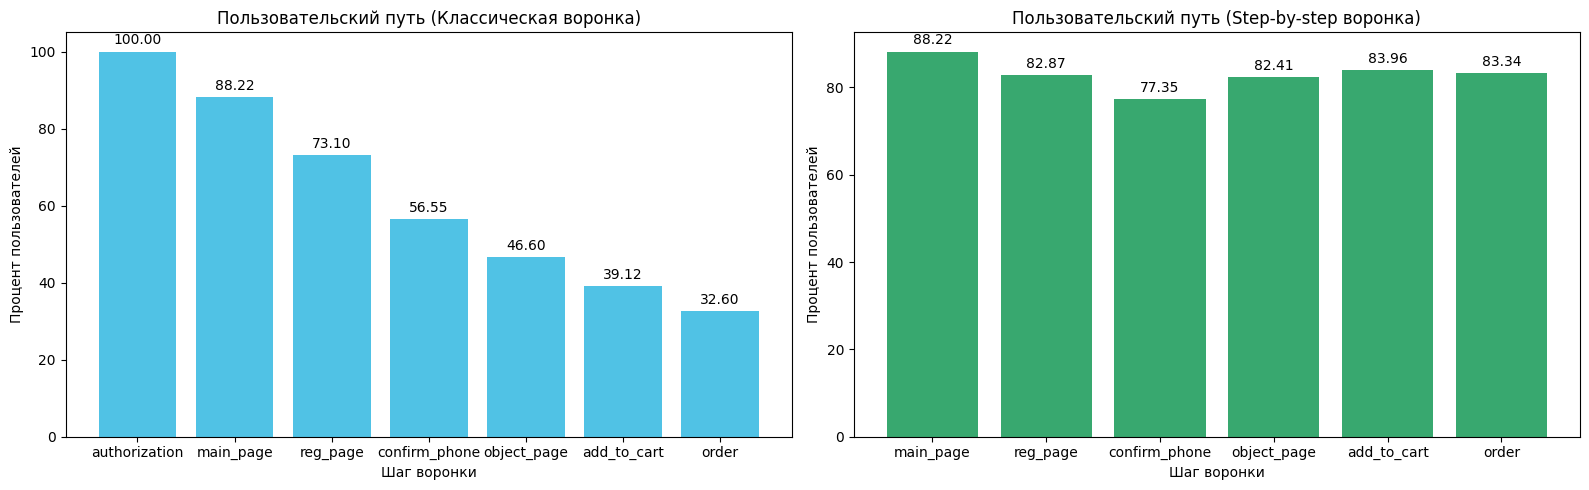

In [10]:
# шаги воронки
funnel_steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 
                'object_page', 'add_to_cart', 'order']

# фильтруем по шагам
fun_step_data = data[data['event'].isin(funnel_steps)]

# считаем число уникальных пользователей на каждом шаге
funnel = fun_step_data.groupby('event')['user_id']\
            .nunique()\
            .reindex(funnel_steps)\
            .reset_index(name='usr_cnt')\
            .rename(columns={'event':'step'})

# классич.
funnel['cr_from_first'] = funnel.loc[:, 'usr_cnt'] *100 / \
                            funnel.loc[0, 'usr_cnt']

# step by step   
funnel['cr_from_prev'] = funnel.loc[:, 'usr_cnt'] *100 / \
                            funnel.shift(1).loc[:, 'usr_cnt']

# строии графики
fig, ax = plt.subplots(1, 2,figsize=(16, 5))
for i, (met,title) in enumerate([('cr_from_first', 'Классическая'),
                                ('cr_from_prev', 'Step-by-step')]):
    bars = ax[i].bar(funnel['step'], funnel[met], color=pal[i+1])
    ax[i].set_title(f'Пользовательский путь ({title} воронка)')
    ax[i].set_xlabel('Шаг воронки')
    ax[i].set_ylabel('Процент пользователей')
    ax[i].bar_label(bars, fmt='%.2f', padding=3)
    # ax[i].set_ylim(0, 110)
    # ax[i].tick_params(axis='x', labelrotation=0)

plt.tight_layout()  # корректируем отступы для всей фигуры
plt.show()


**классическая воронка**
- аномалий не наблюдается  - снижение конверсии постепенное, без резких скачков
- до покупки доходит 32.6% авторизовавшихся пользователей, что довольно высокий показатель для любого бизнеса


**step-by-step воронка** 
- также не выявила критических аномалий
- есть небольшое снижение конверсии из регистрация в подтверждение номера телефона - теряется около 23% пользователей,  
при среднем значении около 16%-17%. 
- стоит обратить внимание на этот шаг `confirm_page` - возможно следует доработать интерфейс, или перенести   
подтверждение на более поздний этап

### 2.2. Сравнение воронок по платформам (Mobile vs Desktop)

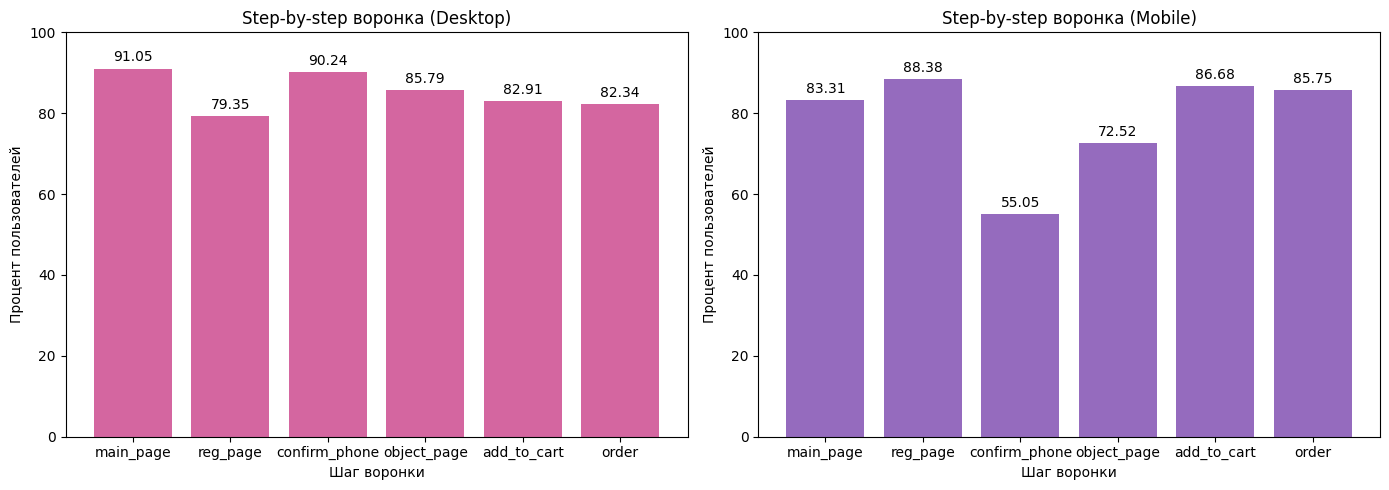

In [11]:
funnel_steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 
                'object_page', 'add_to_cart', 'order']

# фильтруем по шагам воронки
fun_step_data = data[data['event'].isin(funnel_steps)]

fig, ax = plt.subplots(1, 2,figsize=(14, 5))

for i, dev in enumerate(fun_step_data['device_type'].unique()):
    # выбираем устройство
    dev_funnel = fun_step_data[fun_step_data['device_type']==dev]
    
    # считаем число уникальных пользователей на каждом шаге
    fun_plot = dev_funnel.groupby('event')['user_id']\
                .nunique()\
                .reindex(funnel_steps)\
                .reset_index(name='usr_cnt')\
                .rename(columns={'event':'step'})

    # step by step cr  
    fun_plot['cr_from_prev'] = fun_plot.loc[:, 'usr_cnt'] *100 / \
                                fun_plot.shift(1).loc[:, 'usr_cnt']

    # строим график
    bars = ax[i].bar(fun_plot['step'], fun_plot['cr_from_prev'], color=pal[i+3])
    ax[i].set_title(f'Step-by-step воронка ({dev})')
    ax[i].set_xlabel('Шаг воронки')
    ax[i].set_ylabel('Процент пользователей')
    ax[i].bar_label(bars, fmt='%.2f', padding=3)
    ax[i].set_ylim(0, 100)
    # ax[i].tick_params(axis='x', labelrotation=0)

plt.tight_layout()
plt.show()


**Desktop**
- наблюдается небольшая просадка конверсии на этапе регистраци "reg_page" (cr = 79%)  
- также можно заметить на шагах добавления в корзину и покупки конверсия в декстопной версии чуть ниже конверсии в   
мобильных устройств. Это может быть точкой роста трафика. 

**Mobile**
- выявлена критическая просадка конверсии на этапе подтверждения номера телефона (cr = 55%). 
- возможные причины - технические проблемы (доставка SMS/push) или недоработки в UX/UI.
- есть небольшое снижение конверсии на странице товара (cr=72.5%)
- низкая конверсия на шаге главной страницы в сравнений с десктопной версией. Возможно страница долго загружается или  
в целом не оптимизирован UX.

---

## 3. RFM-сегментация пользователей

### 3.1. Расчет RFM-метрик (Recency, Frequency, Monetary)

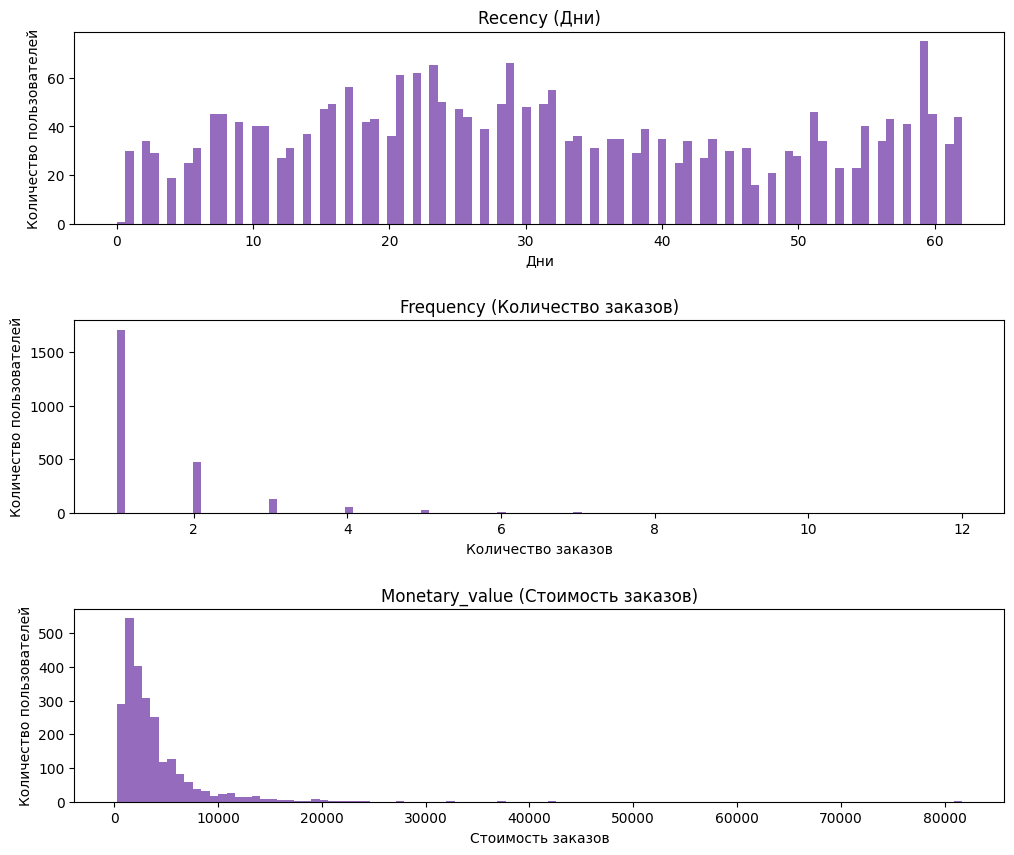

In [12]:
# оставим только покупки
purchases = data[data['event']=='order'].copy()

purchases['recency_order'] =  (pd.to_datetime('2021-07-03') - 
                               purchases['datetime']).dt.days
# находим распределения r,f,m
data_rfm = purchases.groupby('user_id').agg(
    recency = ('recency_order', lambda x: x.min()),
    frequency = ('order_id', 'nunique'),
    monetary_value = ('revenue', 'sum')
).reset_index()

# Строим три гистограммы
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

metrics= [   
    ('recency', 'Дни'),
    ('frequency', 'Количество заказов'),
    ('monetary_value', 'Стоимость заказов'),
]

for i, (met, xlabel) in enumerate(metrics):
    axes[i].hist(data_rfm[met], bins=100, color=pal[4])
    axes[i].set_title(f'{met.capitalize()} ({xlabel})')
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Количество пользователей')

plt.subplots_adjust(hspace=0.5)  
plt.show()

**давность** (Recency)
- пользователи по давности последней покупки распределены неравномерно, но без ярко выраженных особенностей
- есть большой разброс в значениях от 20 до 70 пользователей в разные периоды времени.

**частота покупок** (Frequency)
- частота покупок (количество заказов) имеет ярко выраженную правостороннюю асимметрию
- большинство покупателей совершают не более 3 покупок

**сумма трат** (Monetary).
- также ярко выраженная правосторонняя скошенность
- стоимость заказов лежит в более широком диапазоне до ~80 тыс. руб.
- при этом основная часть заказов лежит в диапазоне примерно до 10 тыс руб

### 3.2. Анализ и интерпретация RFM-сегментов
- **Recency** — три равные группы.
- **Frequency** — три группы: 1 заказ, 2 заказа, 3 и более заказов
- **Monetary** — три группы: 33 перцентиль, 66 перцентиль и оставшиеся.

In [13]:
# Определяем отдельные группы по кол-ву дней, кол-ву заказов и сумме стоимости
data_rfm['r'] = pd.cut(data_rfm['recency'], bins=3, labels=[3,2,1])
data_rfm['f'] = pd.cut(data_rfm['frequency'], bins=[1, 2, 3, 1E9],
                       include_lowest=True,labels=[1,2,3])
data_rfm['m'] = pd.qcut(data_rfm['recency'], q=3, labels=[1,2,3])

# групповой RFM индекс
data_rfm[['r','f','m']] = data_rfm[['r','f','m']].astype('str')
data_rfm['rfm_group'] = data_rfm['r'] + data_rfm['f'] + data_rfm['m']


data_rfm_gr = data_rfm.groupby('rfm_group')['user_id'].nunique()\
             .sort_values(ascending=False).reset_index(name='usr_cnt')

total_users = data_rfm_gr['usr_cnt'].sum()

data_rfm_gr['usr_share_%'] = (data_rfm_gr['usr_cnt'] *100 / total_users).round(1)
display(Markdown(data_rfm_gr.to_markdown()))

|    |   rfm_group |   usr_cnt |   usr_share_% |
|---:|------------:|----------:|--------------:|
|  0 |         212 |       717 |          29.7 |
|  1 |         113 |       684 |          28.3 |
|  2 |         311 |       676 |          28   |
|  3 |         222 |        57 |           2.4 |
|  4 |         211 |        53 |           2.2 |
|  5 |         213 |        52 |           2.2 |
|  6 |         321 |        39 |           1.6 |
|  7 |         232 |        39 |           1.6 |
|  8 |         331 |        34 |           1.4 |
|  9 |         123 |        30 |           1.2 |
| 10 |         133 |        19 |           0.8 |
| 11 |         221 |         4 |           0.2 |
| 12 |         223 |         4 |           0.2 |
| 13 |         231 |         4 |           0.2 |
| 14 |         233 |         4 |           0.2 |

На основе RFM-анализа выделены три ключевых сегмента:

**1. Массовый сегмент с низкой частотой покупок (212, 311):**
- составляют ~60% всей клиентской базы.
- характеризуются низкой частотой (F=1) и низким/средним чеком (M=1, M=2).
- основная аудитория
- требуется стратегии по активации и стимулированию второй покупки.

**2. Крупные "спящие" клиенты (113):**
- составляет 28.3%,  
- характеризуется высоким чеком (M=3), но низкой частотой (F=1) и давностью (R=1).
- самая рискованная и одновременно самая перспективная группа для роста LTV. 
- ключевая задача - их реактивация.

**3. Лояльные и перспективные клиенты (сегменты 233, 223, 133):**
- небольшая группа (< 1%), 
- характеризуются самой высокой частотой и/или чеком.
- ядро лояльной аудитории. 
- основная задача - их удержание и предотвращение перехода в "спящие" сегменты.


---

## 4. K-Means кластеризация ресторанов

### 4.1. Подготовка признаков для кластеризации

In [14]:
# фильтруем покупки
orders = data[data['event']=='order'].copy()

# доход сервиса идет с комиссии 
orders['platform_revenue'] = orders['commission'] * orders['revenue']

# считаем агр. показатели
data_gr =  orders.groupby('rest_id').agg(
    order_cnt = ('order_id', 'nunique'), 
    avg_revenue = ('platform_revenue', 'mean'),
    unique_dish_cnt=('object_id', 'nunique') 
).sort_values(by='order_cnt',ascending=False)

# data_gr['total_revenue'] = data_gr['order_cnt'] * data_gr['avg_revenue']
# data_gr.sort_values(by='total_revenue',ascending=False, inplace=True)

display(Markdown(data_gr.to_markdown()))

| rest_id                          |   order_cnt |   avg_revenue |   unique_dish_cnt |
|:---------------------------------|------------:|--------------:|------------------:|
| 8d9fb9d5992f400eaf02660973a66adf |        1199 |      116.15   |                91 |
| 55d4027ac83e438f9f893892f6903409 |        1001 |      133.733  |                75 |
| 8c9307a1485d4f8aa48c6746e46540d8 |         184 |      105.065  |                13 |
| 8d4f8073da2945c6bd8615fa95c74852 |         163 |      319.28   |                 3 |
| 1be5a933aab34fbab594bebba48e976e |         144 |      180.814  |                28 |
| 56edd124dfa44656afe0c0d041eba562 |         135 |       60.3094 |                 3 |
| 1d6bb74687104fa1953924c9684fe624 |         108 |      236.741  |                19 |
| 4a693ca500b44ba499f92a724aec5f17 |         107 |      179.375  |                12 |
| 815a6b063cd84005b02b1fc3b48af951 |         102 |       71.1329 |                21 |
| a29747e18d3f4ff487b355d34312aacb |          94 |      249.577  |                 9 |
| 59fc1a894303462e8205a759d906499c |          77 |      131.218  |                 6 |
| 5b262d151ec1410e94602e422c525c3d |          48 |      102.413  |                 6 |
| 43e40bacafe8409bb5592877a42d737e |          43 |      132.523  |                 6 |
| 3247a3b5f9494812a3c1a73c5b61f004 |          33 |      222.177  |                 4 |
| 39b7eab4f4704ed2886fafe171489960 |          33 |      221.24   |                 5 |
| c91517a6ca264aadae9725e1774d93ca |          23 |      118.452  |                 1 |
| a59b5279a8674d7a8a16fbf5d92b5551 |          23 |      119.992  |                 6 |
| fe285c3040794705afbc17089aafc687 |          12 |       78.2833 |                 2 |
| 2c6095730b514c189ee41c65f03febc3 |           8 |      100.38   |                 4 |
| 4b9cde3378c447ed81c2c6d4854d4f7e |           7 |      127.2    |                 5 |
| 55d6470712ee48e98509478ad6aa18ee |           5 |      285.264  |                 2 |

### 4.2. Определение оптимального числа кластеров (Метод локтя)


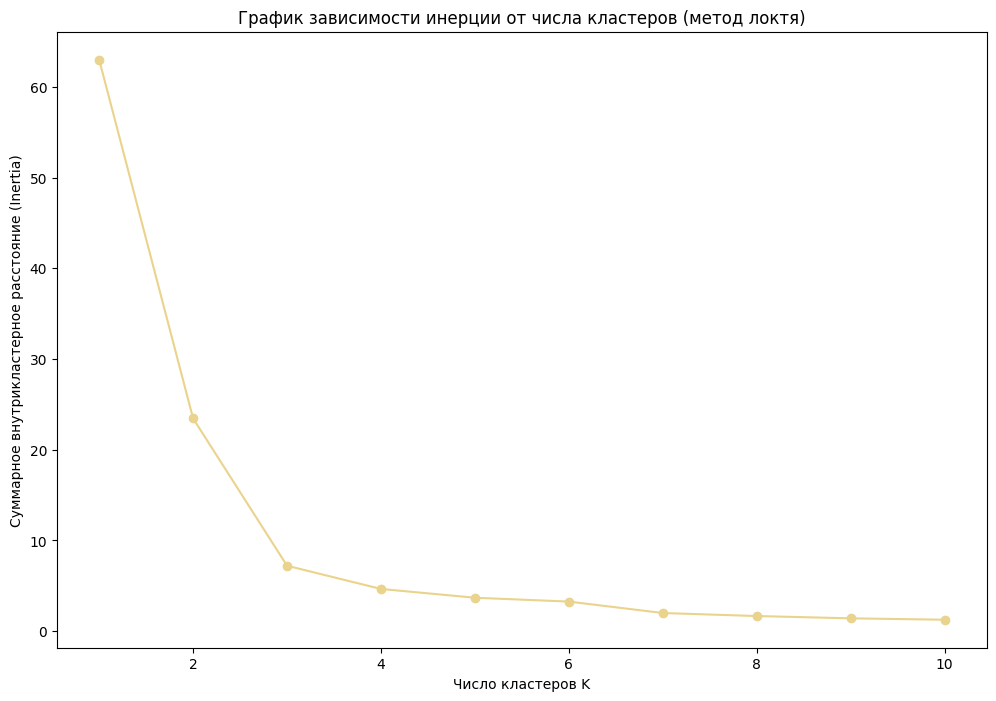

In [15]:
# inertia 
i = []

# Задаём диапазон количества кластеров
min_k, max_k = 1,10 
plt.figure(figsize=(12, 8))

# нормализуем признаки (приведем к одному масштабу) 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_gr)

# Перебираем разное количество кластеров
for k in range(min_k, max_k + 1):
   km = KMeans(n_clusters=k)  # Создаём модель KMeans для текущего значения k
   km.fit_transform(data_scaled)  # Обучаем модель и получаем координаты точек
   i.append(km.inertia_)  # Сохраняем значение инерции для текущего k

# Строим график зависимости инерции от количества кластеров
plt.plot(range(min_k, max_k + 1), i, marker='o', color=pal[6])
plt.xlabel('Число кластеров K')  # Подпись оси X
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')  # Подпись оси Y
plt.title('График зависимости инерции от числа кластеров (метод локтя)')  # Заголовок
plt.show()

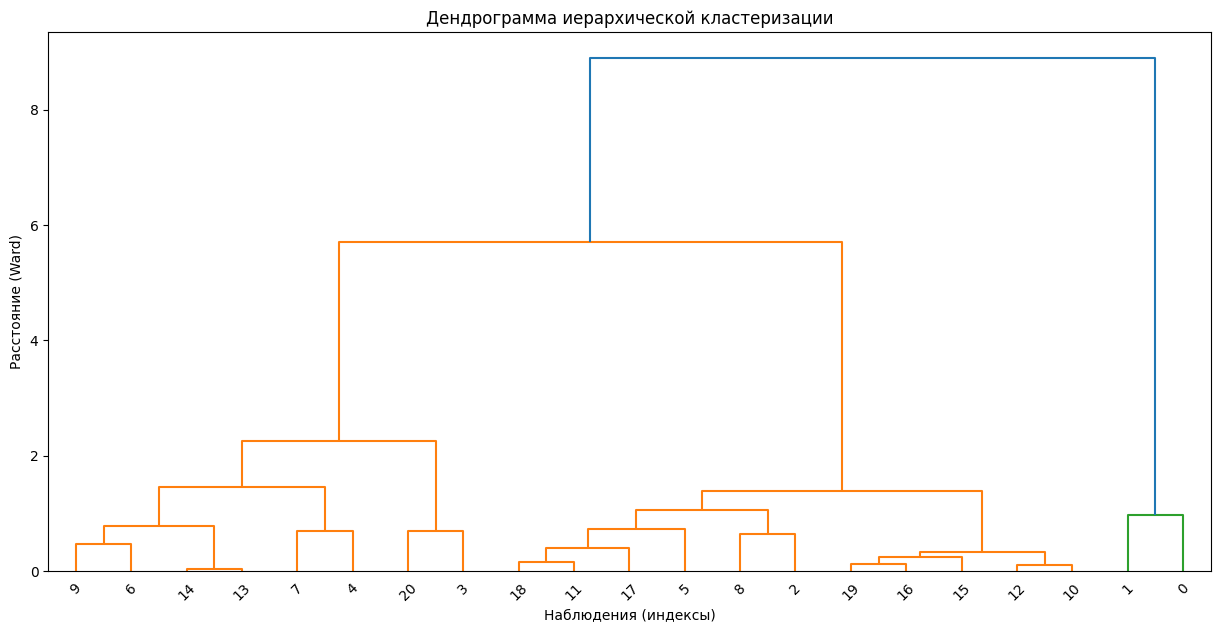

In [16]:
# импортируем нужные библиотеки
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Вычисляем матрицу связей между объектами.
# Метод 'ward' стремится минимизировать дисперсию внутри кластеров,
# что похоже на логику K-Means.
# Важно: для этого метода, как и для K-Means, нужно использовать масштабированные данные!
linked = linkage(data_scaled, method='ward')

# Задаем размер графика для наглядности
plt.figure(figsize=(15, 7))

# Строим дендрограмму
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Наблюдения (индексы)')
plt.ylabel('Расстояние (Ward)')
plt.show()

**В данном случае, разумным выглядит разбиение на 3 кластера**

### 4.3. Анализ и интерпретация кластеров

In [ ]:
# Проведем кластеризацию в признаковом пространстве: 
# "кол-во заказов", "средний чек" и "кол-во блюд"

# Фиксируем seed, обучем модель на нормализованных данных 
kmeans = KMeans(n_clusters= 3, random_state=42)
labels = kmeans.fit_predict(data_scaled)

# Преобразуем центроидов обратно
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# сортируем по кол-ву заказов - признак 0
sorted_indices = np.argsort(-centroids[:, 0])
sorted_centroids = centroids[sorted_indices]

# Создаём DataFrame из центроидов
centroids_df = pd.DataFrame(
   sorted_centroids,
   columns=["кол-во заказов", "средний чек", "кол-во блюд" ],
   index=[f'Кластер {i + 1}' for i in range(kmeans.n_clusters)]
)


# Перекодируем метки кластеров согласно новой нумерации
new_labels = np.empty_like(labels)
for new_id, old_id in enumerate(sorted_indices):
    new_labels[labels == old_id] = new_id
labels = new_labels  # Заменяем старые метки


# Подсчёт количества ресторанов в каждом кластере
cluster_counts = pd.Series(new_labels).value_counts().sort_index()
centroids_df['Кол-во ресторанов'] = cluster_counts.values

# Форматируем вывод и выводим 
pd.options.display.float_format = '{:.0f}'.format
print(centroids_df)


           кол-во заказов  средний чек  кол-во блюд  Кол-во ресторанов
Кластер 1            1100          125           83                  2
Кластер 2              86          237           10                  8
Кластер 3              60          104            7                 11


**Кластер 1**
- максимальное число заказов (1100) и блюд (83 в 8 раз больше чем в остальных) 
- средний чек 125 руб
- наиболее важный кластер - приносит основной доход.

**Кластер 2**
- кол-во закзов в 11 раз меньше (86), но зато средний чек почти в 2 раза выше (237 руб) 
- приносит в 7 раз меньше дохода чем кластер 1, но тем не менее на 2 месте важности

**Кластер 3**
- заказов чуть меньше чем в кластере 2 (60) и ср. чек меньше в 2 раза (104 руб) 

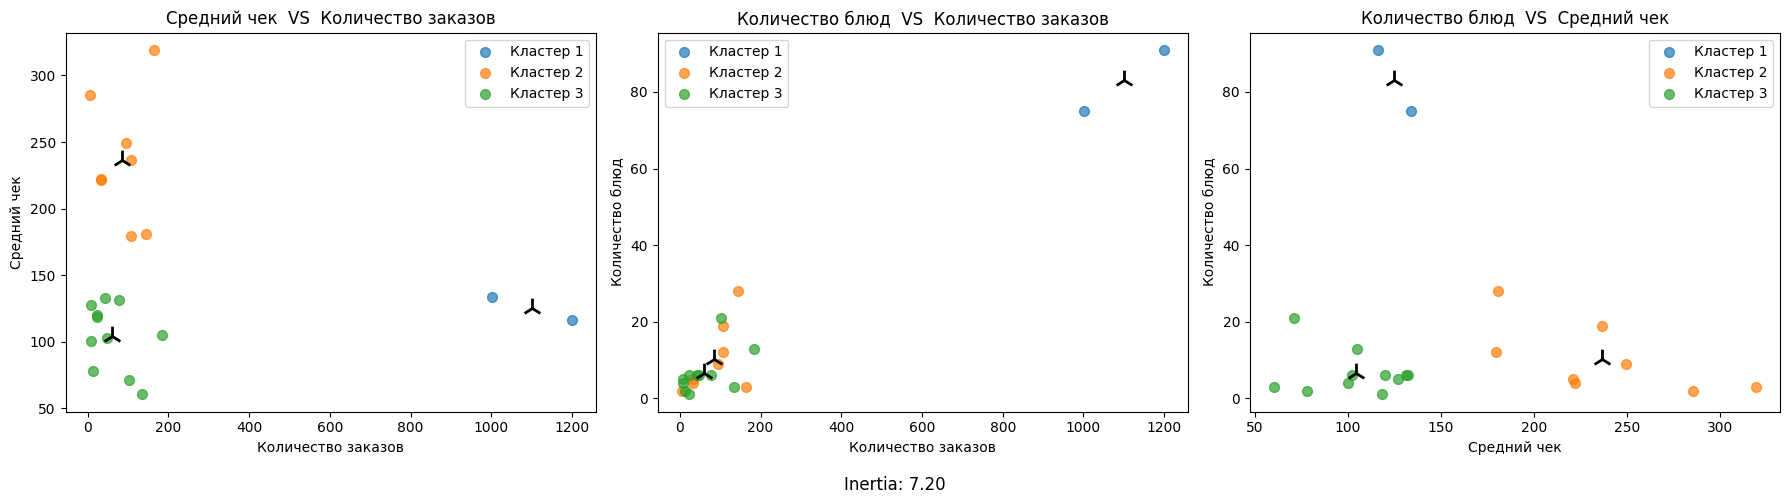

In [23]:
# Создаём 3 графика 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # список названий признаков
axs = ['order_cnt', 'avg_revenue', 'unique_dish_cnt']
# cluster_names = [f'Кластер {x}' for x in range(1,5)]

ax_names = {
    'order_cnt': "Количество заказов",
    'avg_revenue': "Средний чек",
    'unique_dish_cnt': "Количество блюд"
}

# Перебираем пары признаков:
for i, (x_idx, y_idx) in enumerate([[0, 1], [0, 2], [1, 2]]):
    # признаки и названия осей
    x_feat, y_feat = axs[x_idx], axs[y_idx] 
    x_name, y_name = ax_names[x_feat], ax_names[y_feat]
    
    for cl_id, cl_name in enumerate(centroids_df.index):
        mask = (labels == cl_id)  # Выбираем точки кластера
        axes[i].scatter(
            data_gr.loc[mask, x_feat],
            data_gr.loc[mask, y_feat],
            label=cl_name,
            s=50,
            alpha=0.7
        )
        
    # Строим центроиды кластеров 
    axes[i].scatter(
        sorted_centroids[:, x_idx],  # X-координаты центров
        sorted_centroids[:, y_idx],  # Y-координаты центров
        s=200,  # Размер маркеров
        c='k',
        #edgecolors='k',
        linewidths=2,
        marker='2'
    )

    # Подписи осей и заголовок
    axes[i].set_xlabel(x_name)
    axes[i].set_ylabel(y_name)
    axes[i].set_title(f'{y_name}  VS  {x_name}')
    axes[i].legend()
   
# Подгоняем макет, оставляя место снизу для подписи с инерцией
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Добавляем текст с СВР под графиком 
fig.text(0.5, 0.01, f'Inertia: {kmeans.inertia_:.2f}', ha='center', fontsize=12)

plt.show()

**средний чек в зависимости от количества заказов**
- можно условно выделить 3 диапазона ср. чека
    - 50 - 150 руб - кластер 3
    - 110 - 130 руб - кластер 1
    - 170 - 320 руб - кластер 2
- количество заказов в 3 и 2 кластере в основном не превышают 200 штук
- кластер 1 имеет аномально высокое количество заказов - 1000 - 1200 штук

**количество блюд в зависимости от количества заказов.**
- 2 и 3 кластеры расположены очень компактно в области до 30 блюд и до 200 заказов
- кластер 1 аномально высокие показатели заказов (1000 - 1200 шт.) наряду с богатым ассортиментом - около 70-90 блюд


**количество блюд в зависимости от ср. чека**
- количество блюд в основном не превышает 30
- аномальное количество блюд наблюдается только в кластере 1 (70-90 шт.)

---

## 5. Итоговые выводы и рекомендации

### Ключевые выводы

1.  **Поведение пользователей (Воронка):**
    - **Критическая проблема:** Обнаружено падение конверсии на 45% на этапе подтверждения телефона в мобильной версии  
    (CR=55%).
    - **Потенциальный эффект:** Устранение этой проблемы может увеличить общее количество заказов до 50%.

2.  **Сегменты клиентов (RFM-анализ):**
    - **Массовый сегмент (212, 311):** Около 60% клиентов совершают покупки редко и имеют низкий/средний чек, что  
    указывает на общую проблему с вовлеченностью.
    - **Крупные "спящие" клиенты (113):** Крупный сегмент (28.3%) с высоким чеком, который давно не возвращался. Это  
    главная точка роста LTV, но и самый высокий риск.
    - **Лояльное ядро (<1%):** Небольшие, но самые ценные сегменты (233, 223, 133) с высокой частотой и/или чеком.  
    Ключевая задача — их удержание.


3.  **Сегменты партнеров (K-Means кластеризация):**
    - **Основной источник дохода:** Выделен ключевой кластер ресторанов, который генерирует основной объем заказов  
    (до 1100) за счет очень широкого ассортимента (70-90 блюд) при среднем чеке.

### Рекомендации

**Приоритетная задача: Исправить падение конверсии в мобильной версии:**
- Возможные проблемы: доставка SMS/push-уведомлений, неинтуитивный интерфейс.
- Решение: Провести UX-исследование этапа подтверждения телефона.

**Повысить частоту покупок у массового сегмента.**
- Для сегментов 212 и 311 (почти 60% базы) разработать и протестировать кампании, направленные на стимулирование второй  
покупки.

**Улучшить удержание и повысить LTV существующих клиентов.**
- Запустить программу лояльности, начав с самых ценных сегментов (233, 223, 133), чтобы предотвратить их отток.
- Провести A/B-тест кампании по реактивации "спящих" крупных клиентов (113) на небольшой выборке из сегмента.

**Укрепить отношения с ключевыми партнерами.**
- Разработать специальные условия для ресторанов из самого прибыльного кластера (с широким ассортиментом), чтобы  
стимулировать их активность и удержание на платформе.